# DATASET EXPLORER: Batch Selection Project

Author: Laura Tomokiyo
AI Assistance: ChatGPT

This notebook illustrates how to load and inspect a number of common ML benchmark datasets.  

In [2]:
# Initial imports
import os
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import pandas as pd
import PIL
import random
import torch
from datasets import load_dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset, DataLoader

transform = transforms.ToTensor()
SAVE_DATA_SAMPLES=False

In [ ]:
# For saving data to a static directory for further inspection/display (optional)
# SAVE_DATA_SAMPLES=True

if SAVE_DATA_SAMPLES:
    SAVEDIR='static_samples' 
    from torchvision.transforms.functional import to_pil_image
    from torchvision.utils import save_image
    safe = lambda s: re.sub(r"[^A-Za-z0-9._-]+", "_", s)


In [ ]:
# Optional: some environment printouts
# possibly helpful in getting compatible versions.
# I used numpy 1.26.4, torchvision 0.23.0+cu128, pillow 9.5.0

import sys
print('---')
print("path:", sys.path)
print('---')
print("numpy location:", np.__file__)
print("numpy version:", np.__version__)
print("python executable:", sys.executable)
print("torchvision:", torchvision.__version__)
print("pillow version:", PIL.__version__)
print(PIL.__file__)
print("pandas:", pd.__version__, pd.__file__)

In [3]:
# Shared data directory
DATASETS_DIR = "/storage/ice-shared/cs8903onl/lw-batch-selection/datasets"

# Subdirectories for each dataset
# Vision datasets
CIFAR100_DIR   = os.path.join(DATASETS_DIR, "vision/cifar100")
CIFAR10_DIR    = os.path.join(DATASETS_DIR, "vision/cifar10")
MNIST_DIR      = os.path.join(DATASETS_DIR, "vision/MNIST")
QMNIST_DIR     = os.path.join(DATASETS_DIR, "vision/qmnist")
SVHN_DIR       = os.path.join(DATASETS_DIR, "vision/svhn")
SVHN_FULL_DIR  = os.path.join(DATASETS_DIR, "vision/svhn-full")
IMAGENET_DIR   = os.path.join(DATASETS_DIR, "vision/imagenet-2012")
TINY_IMAGENET_DIR = os.path.join(DATASETS_DIR, "vision/tiny-imagenet-200")
CLOTHING1M_DIR = os.path.join(DATASETS_DIR, "vision/clothing-1m")
VOC2012_DIR    = os.path.join(DATASETS_DIR, "vision/voc2012")
CINIC10_DIR    = os.path.join(DATASETS_DIR, "vision/CINIC-10")
WIKI_DIR     = os.path.join(DATASETS_DIR, "vision/wikipedia_dataset")


# NLP datasets
COLA_DIR = os.path.join(DATASETS_DIR, "nlp/cola")
SST2_DIR = os.path.join(DATASETS_DIR, "nlp/sst2")
E2ENLG_DIR     = os.path.join(DATASETS_DIR, "nlp/e2e-dataset")


# Check
print("CIFAR100_DIR =", CIFAR100_DIR)
print("VOC2012_DIR  =", VOC2012_DIR)

CIFAR100_DIR = /storage/ice-shared/cs8903onl/lw-batch-selection/datasets/vision/cifar100
VOC2012_DIR  = /storage/ice-shared/cs8903onl/lw-batch-selection/datasets/vision/voc2012


In [4]:
# Helper functions 

def show_dataset_stats(dataset, name="Dataset", is_nlp=False):
    print(f"📊 {name}")
    print("-" * (len(name) + 4))
    if is_nlp and hasattr(dataset, "keys"):
        for split in dataset.keys():
            print(f"{split}: {len(dataset[split])} samples")
    else:
        print(f"Number of samples: {len(dataset)}")
        if hasattr(dataset, "classes"):
            print(f"Number of classes: {len(dataset.classes)}")
            print(f"Example classes: {dataset.classes[:10]}")
    print()

def show_samples(dataset, num_samples=5, is_nlp=False, save_samples=False, savedir='static_samples'):
    if is_nlp and hasattr(dataset, "keys"):
        split = "train" if "train" in dataset else list(dataset.keys())[0]
        rows = []
        for i in random.sample(range(len(dataset[split])), k=num_samples):
            rows.append({k: (v.item() if hasattr(v, "item") else v) 
                         for k, v in dataset[split][i].items()})
        display(pd.DataFrame(rows))
    else:
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i in range(num_samples):
            img, label = dataset[i]
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
            else:
                img_np = np.array(img)
            axes[i].imshow(img_np.squeeze(), cmap="gray" if img_np.ndim == 2 else None)
            axes[i].set_title(getattr(dataset, "classes", [])[label] if hasattr(dataset, "classes") else label)
            axes[i].axis("off")
        plt.show()
        
def show_split_sizes_pt(name, train=None, val=None, test=None, classes=None):
    print(f"📊 {name}")
    print("-" * (len(name) + 4))
    if train is not None: print(f"Training set samples: {len(train)}")
    if val   is not None: print(f"Validation set samples: {len(val)}")
    if test  is not None: print(f"Test set samples: {len(test)}")
    if classes is None and train is not None and hasattr(train, "classes"):
        classes = train.classes
    if classes is not None:
        ex = list(classes)[:10]
        print(f"Number of classes: {len(classes)}")
        print(f"Example classes: {ex}")
    print()
    
def show_split_sizes_hf(ds_dict, name, label_field=None, show_example_labels=True):
    print(f"📊 {name}")
    print("-" * (len(name) + 4))
    for split in ("train", "validation", "test"):
        if split in ds_dict:
            print(f"{split}: {len(ds_dict[split])} samples")
    # Try to show label examples if requested
    if show_example_labels and "train" in ds_dict:
        ex = ds_dict["train"][0]
        # Heuristics to find label field if not provided
        if label_field is None:
            for k in ("label", "labels", "category"):
                if k in ex:
                    label_field = k
                    break
        if label_field and label_field in ex:
            print(f"example label field: '{label_field}' (first example value: {ex[label_field]})")
    print()
    
# HuggingFace datasets return dicts → wrap them in a PyTorch Dataset to enable DataLoader
def hf_to_torch(dataset, text_field="sentence", label_field="label"):
    return [(ex[text_field], torch.tensor(ex[label_field])) for ex in dataset]



## Vision Datasets

### CIFAR
CIFAR-10, CIFAR-100: train/test \
CIFAR-100-LT: training set derived from CIFAR-100 \
Source: torchvision.datasets \
Cite: CIFAR-100, CIFAR-10: Krizhevsky, A. and Hinton, G. [Learning multiple layers of
features from tiny images. Master’s thesis](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Department of Computer Science, University of Toronto, 2009\
Cite CIFAR-LT: Cui, Yin, et al. "[Class-balanced loss based on effective number of samples](https://arxiv.org/pdf/1901.05555)." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019.


#### CIFAR-100

📊 CIFAR-100 (train)
---------------------
Number of samples: 50000
Number of classes: 100
Example classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']

📊 CIFAR-100 (test)
--------------------
Number of samples: 10000
Number of classes: 100
Example classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']



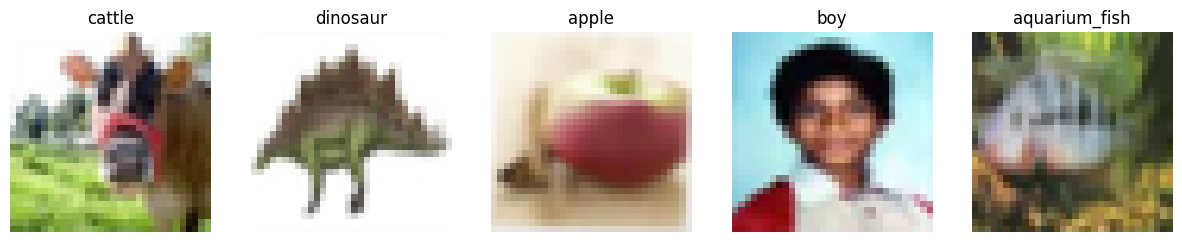

In [5]:
# Load and inspect dataset 

cifar100_train = datasets.CIFAR100(root=CIFAR100_DIR, train=True, download=False, transform=transform)
cifar100_test  = datasets.CIFAR100(root=CIFAR100_DIR, train=False, download=False, transform=transform)

show_dataset_stats(cifar100_train, name="CIFAR-100 (train)")
show_dataset_stats(cifar100_test, name="CIFAR-100 (test)")

# Show samples explicitly
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img, label = cifar100_train[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(cifar100_train.classes[label])
    ax.axis("off")
    
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'cifar100')
        os.makedirs(OUTDIR,exist_ok=True)
        # save each sample next to the notebook, e.g., static_samples/CIFAR100_train/000_dog.png
        fn = os.path.join(OUTDIR,f"{i:03d}_{cifar100_train.classes[label]}.png")
        print(f'saving {fn}')
        save_image(img,fn)
plt.show()


In [6]:
# Create demo dataloader 
train_loader = DataLoader(cifar100_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

Batch images shape: torch.Size([4, 3, 32, 32])
Batch labels: [85, 2, 74, 21]
Number of batches in train loader:  12500


#### CIFAR-100-LT
This "long-tail" subset is dynamically generated to be imbalanced. It seems that while the training subset is purposefully balanced in these experiments, the test subset is kept the same (i.e. balanced)

📊 CIFAR-100-LT Train
----------------------
Number of samples: 10847

Imbalance ratio: 100
Examples per class (first 10): [500, 477, 455, 434, 415, 396, 378, 361, 344, 328]


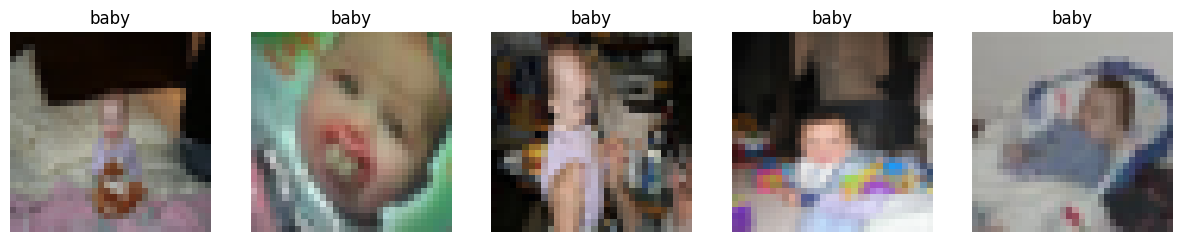

In [7]:
from torch.utils.data import Subset

# === Parameters ===
IR = 100  # imbalance ratio (max/min class frequency)
transform = transforms.ToTensor()

# === Load CIFAR-100 train ===
cifar100_train = datasets.CIFAR100(
    root=CIFAR100_DIR,
    train=True,
    download=False,
    transform=transform
)

# === Compute long-tailed distribution ===
cls_num = len(cifar100_train.classes)  # 100
img_max = len(cifar100_train) // cls_num  # ~500 per class
img_num_per_cls = [
    int(img_max * (IR ** (-i / (cls_num - 1.0)))) for i in range(cls_num)
]

# === Subsample indices ===
targets = np.array(cifar100_train.targets)
lt_indices = []
for cls, num in enumerate(img_num_per_cls):
    cls_indices = np.where(targets == cls)[0]
    np.random.shuffle(cls_indices)
    lt_indices.extend(cls_indices[:num])

cifar100_lt_train = Subset(cifar100_train, lt_indices)

# === Show stats and samples ===
show_dataset_stats(cifar100_lt_train, name="CIFAR-100-LT Train")
print(f"Imbalance ratio: {IR}")
print("Examples per class (first 10):", img_num_per_cls[:10])

#show_samples(cifar100_lt_train, num_samples=5) # doesn't get the sampling right
classes = getattr(cifar100_train, "classes", None) # get CIFAR-100 class names, which don't live in subset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    orig_idx = cifar100_lt_train.indices[i+1000]
    img,label = cifar100_train[orig_idx]
    lbl = int(label) if not torch.is_tensor(label) else int(label.item())
    cls = classes[lbl] if (classes and 0<=lbl<len(classes)) else str(lbl)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(cls)
    ax.axis("off")

    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'cifar100-lt')
        os.makedirs(OUTDIR,exist_ok=True)
        orig_idx = cifar100_lt_train.indices[i]
        img,label = cifar100_train[orig_idx]
        lbl = int(label) if not torch.is_tensor(label) else int(label.item())
        cls = classes[lbl] if (classes and 0<=lbl<len(classes)) else str(lbl)
        fn = os.path.join(OUTDIR, f"{i:03d}_orig{orig_idx:05d}_{cls.replace(' ', '_')}.png")
        print(f'saving {fn}')
        save_image(img, fn)
plt.show()


In [8]:
# Create demo dataloader 
train_loader = DataLoader(cifar100_lt_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

Batch images shape: torch.Size([4, 3, 32, 32])
Batch labels: [0, 24, 19, 32]
Number of batches in train loader:  2712


#### CIFAR-10

📊 CIFAR-10 Train
------------------
Number of samples: 50000
Number of classes: 10
Example classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

📊 CIFAR-10 Test
-----------------
Number of samples: 10000
Number of classes: 10
Example classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



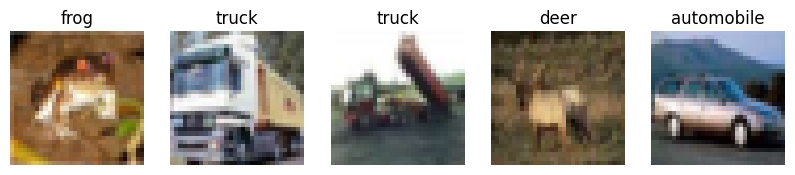

In [9]:
cifar10_train = datasets.CIFAR10(
    root=CIFAR10_DIR,
    train=True,
    download=False,   # use local copy
    transform=transform
)
cifar10_test = datasets.CIFAR10(
    root=CIFAR10_DIR,
    train=False,
    download=False,
    transform=transform
)

# === Show stats ===
show_dataset_stats(cifar10_train, name="CIFAR-10 Train")
show_dataset_stats(cifar10_test, name="CIFAR-10 Test")

# === Show some sample images ===
show_samples(cifar10_train, num_samples=5)

# Save samples
if SAVE_DATA_SAMPLES:
    OUTDIR = os.path.join(SAVEDIR, 'cifar10')
    os.makedirs(OUTDIR,exist_ok=True)
    for i in range(5):
        img, label = cifar10_train[i]
        # save each sample next to the notebook, e.g., static_samples/CIFAR100_train/000_dog.png
        fn = os.path.join(OUTDIR,f"{i:03d}_{cifar10_train.classes[label]}.png")
        print(f'saving {fn}')
        save_image(img,fn)



In [10]:
# Create demo dataloader 
train_loader = DataLoader(cifar10_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

Batch images shape: torch.Size([4, 3, 32, 32])
Batch labels: [1, 1, 3, 3]
Number of batches in train loader:  12500


### MNIST / QMNIST
QMNIST extends MNIST with an extra 50,000 test images.  Splits test10k, test50k (aka "extra"), and nist can be exposed if you load QMNIST through torchvision.datasets.QMNIST with the *what* parameter. These splits are derived from the downloaded files.  

In other words: 

- **train** - 60k (MNIST train)
- **test10k** - 10k (the classic MNIST test set)
- **test50k** - the “extra” 50k (the remainder of the QMNIST test set, sometimes called "extra" in papers)
- **test** - 60k total = test10k + test50k
- **nist** - 60k additional digits sourced from NIST

Source: torchvision.datasets \
Cite QMNIST: Yadav, C. and Bottou, L. [Cold case: The lost mnist digits.](https://proceedings.neurips.cc/paper_files/paper/2019/file/51c68dc084cb0b8467eafad1330bce66-Paper.pdf).
In Advances in Neural Information Processing Systems
32, 2019. \
Cite MNIST: LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. [Gradient-based learning applied to document recognition](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). Proceedings of the IEEE, 86(11):2278–2324, November 1998.


#### QMNIST



In [11]:
qmnist_train = datasets.QMNIST(root=QMNIST_DIR, what="train", download=False, transform=transform)
qmnist_test  = datasets.QMNIST(root=QMNIST_DIR, what="test", download=False, transform=transform)
qmnist_test50k  = datasets.QMNIST(root=QMNIST_DIR, what="test50k", download=False, transform=transform)
qmnist_test10k  = datasets.QMNIST(root=QMNIST_DIR, what="test10k", download=False, transform=transform)
qmnist_nist  = datasets.QMNIST(root=QMNIST_DIR, what="nist", download=False, transform=transform)

show_dataset_stats(qmnist_train, name="QMNIST Train")
show_dataset_stats(qmnist_test, name="QMNIST Test")
show_dataset_stats(qmnist_test50k, name="QMNIST Test50k")
show_dataset_stats(qmnist_test10k, name="QMNIST Test10k")
show_dataset_stats(qmnist_nist, name="QMNIST Nist")

📊 QMNIST Train
----------------
Number of samples: 60000
Number of classes: 10
Example classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

📊 QMNIST Test
---------------
Number of samples: 60000
Number of classes: 10
Example classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

📊 QMNIST Test50k
------------------
Number of samples: 50000
Number of classes: 10
Example classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

📊 QMNIST Test10k
------------------
Number of samples: 10000
Number of classes: 10
Example classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

📊 QMNIST Nist
---------------
Number of samples: 402953
Number of classes: 10
Example classes: ['0 - zero', '1 - one', '2 

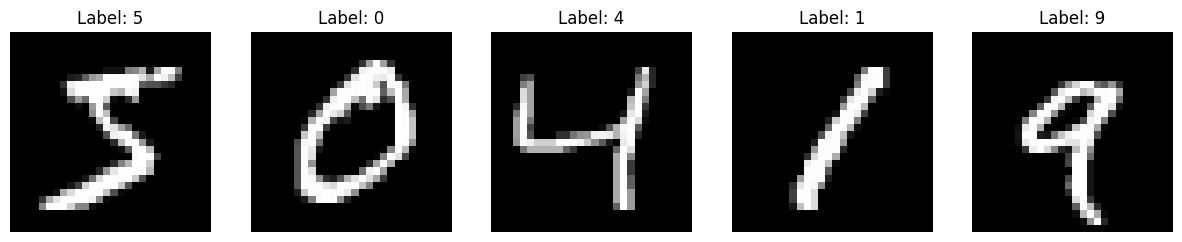

In [12]:
# Inspect samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img, label = qmnist_train[i]
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
    # Save samples
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'qmnist')
        os.makedirs(OUTDIR,exist_ok=True)
        # save each sample next to the notebook, e.g., static_samples/CIFAR100_train/000_dog.png
        fn = os.path.join(OUTDIR,f"{i:03d}_{qmnist_train.classes[label].replace(' - ','_')}.png")
        print(f"saving {fn}")
        save_image(img,fn)
plt.show()




In [ ]:
# Create demo dataloader 
train_loader = DataLoader(qmnist_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

#### MNIST


In [ ]:
# Load train and test splits (without downloading again)
mnist_train = datasets.MNIST(root=MNIST_DIR, train=True, download=False, transform=transform)
mnist_test  = datasets.MNIST(root=MNIST_DIR, train=False, download=False, transform=transform)

# === Show dataset statistics ===
show_dataset_stats(mnist_train, name="MNIST Train")
show_dataset_stats(mnist_test,  name="MNIST Test")

# === Show sample images ===
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = mnist_train[random.randint(0, len(mnist_train)-1)]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'mnist')
        os.makedirs(OUTDIR,exist_ok=True)
        # save each sample next to the notebook, e.g., static_samples/CIFAR100_train/000_dog.png
        fn = os.path.join(OUTDIR,f"{i:03d}_{mnist_train.classes[label].replace(' - ','_')}.png")
        print(f'saving {fn}')
        save_image(img,fn)

plt.show()

In [ ]:
# Create demo dataloader 
train_loader = DataLoader(mnist_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

### PASCAL VOC

Splits: train/validation \
Source: tensorflow datasets, e.g. \
`python -c "import tensorflow_datasets as tfds; voc, info = tfds.load('voc/2012', data_dir='$DATASETS_DIR/vision/voc2012', with_info=True); print(info)"` \
Cite: Everingham, M., Van Gool, L., Williams, C.K.I. et al. [The Pascal Visual Object Classes (VOC) Challenge](https://doi.org/10.1007/s11263-009-0275-4). Int J Comput Vis 88, 303–338 (2010). 


In [ ]:
# VOC images come in a variety of resolutions
# To handle them in PyTorch, we need to apply a transform
# We permute the images to channel-last format for visualization
# A custom collator is needed to address the different image sizes (torch.stack fails)

voc_train = VOCDetection(root=VOC2012_DIR, year="2012", image_set="train", download=False, transform=transform)
voc_val   = VOCDetection(root=VOC2012_DIR, year="2012", image_set="val", download=False, transform=transform)

show_dataset_stats(voc_train, name="Pascal VOC 2012 Train")
show_dataset_stats(voc_val, name="Pascal VOC 2012 Validation")

# The labels in voc can get really long - like if there are 15 potted plants in an image
import re
from collections import Counter

def summarize_labels(labels):
    c = Counter(labels)
    # Pretty title like: "dog ×2, person, pottedplant ×15"
    pretty = ", ".join([f"{k} ×{v}" if v > 1 else k for k, v in c.items()])
    # Safe slug like: "dogx2+person+pottedplantx15"
    slug = "+".join([f"{k}x{v}" if v > 1 else k for k, v in c.items()])
    # sanitize filename segment
    slug = re.sub(r"[^A-Za-z0-9._+-]+", "_", slug)
    return pretty, slug

# Show 5 random VOC samples
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(voc_train)-1)
    img, target = voc_train[idx]
    ann = target["annotation"]
    objects = [obj["name"] for obj in ann["object"]]
    print(f'objects: {objects}')
    ax.imshow(np.array(img.permute(1,2,0).numpy()))

    pretty, slug = summarize_labels(objects)
    ax.set_title(pretty)
    ax.axis("off")
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'voc2012')
        os.makedirs(OUTDIR,exist_ok=True)
        fn = os.path.join(OUTDIR,f"{i:03d}_{slug}.png")
        print(f'saving {fn}')
        save_image(img,fn)

plt.show()


In [ ]:
# VOC images have variable resolutions 
# custom collate keeps images as a list
def voc_collate_fn(batch):
    images, targets = zip(*batch)  # unzip into two tuples
    return list(images), list(targets)

# Create demo dataloader
train_loader = DataLoader(
    voc_train,
    batch_size=2,
    shuffle=True,
    collate_fn=voc_collate_fn  # <-- important!
)
# Create demo dataloader
val_loader = DataLoader(
    voc_val,
    batch_size=2,
    shuffle=True,
    collate_fn=voc_collate_fn  # <-- important!
)

# Inspect one batch
images, targets = next(iter(train_loader))

print("Number of images in batch:", len(images))
print("Image 0 size:", images[0].size)   # original PIL size
print("Image 1 size:", images[1].size)

print("Targets type:", type(targets), "Length:", len(targets))
for i, t in enumerate(targets):
    ann = t["annotation"]
    objects = [obj["name"] for obj in ann["object"]]
    print(f"Sample {i} objects: {objects}")

print("Number of batches in train loader:", len(train_loader))
print("Number of batches in val loader:", len(val_loader))

### CINIC-10
Splits: train/validation/test \
Source: https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz \
Cite: Darlow, Luke N; Crowley, Elliot J; Antoniou, Antreas; Storkey, Amos.(2018). [CINIC-10 Is Not ImageNet or CIFAR-10](https://datashare.ed.ac.uk/handle/10283/3192), [dataset]. University of Edinburgh

In [ ]:
# Load CINIC-10 splits
transform = transforms.ToTensor()

cinic_train = datasets.ImageFolder(root=os.path.join(CINIC10_DIR, "train"), transform=transform)
cinic_val   = datasets.ImageFolder(root=os.path.join(CINIC10_DIR, "valid"), transform=transform)
cinic_test  = datasets.ImageFolder(root=os.path.join(CINIC10_DIR, "test"),  transform=transform)

# === Show dataset statistics ===
show_dataset_stats(cinic_train, name="CINIC-10 Train")
show_dataset_stats(cinic_val,   name="CINIC-10 Validation")
show_dataset_stats(cinic_test,  name="CINIC-10 Test")

# === Show sample images ===
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = cinic_train[random.randint(0, len(cinic_train)-1)]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"Label: {cinic_train.classes[label]}")
    axes[i].axis("off")

    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'CINIC-10')
        os.makedirs(OUTDIR,exist_ok=True)
        # save each sample next to the notebook, e.g., static_samples/CIFAR100_train/000_dog.png
        fn = os.path.join(OUTDIR,f"{i:03d}_{label}.png")
        print(f'saving {fn}')
        save_image(img,fn)

plt.show()


In [ ]:
# Create demo dataloader 
train_loader = DataLoader(cinic_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

### SVHN (Street View House Numbers)

Splits: train/test \
Source: torchvision.datasets \
Cite: Netzer, Y., Wang, T., Coates, A., Bissacco, A., Wu, B., and Ng, A. Y. [Reading digits in natural images with
unsupervised feature learning](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37648.pdf). NIPS workshop on deep learning and unsupervised feature learning. Vol. 2011. No. 5. 2011.

**Note** \
Unlike MNIST or QMNIST, the **SVHN dataset** does not create `raw/` and `processed/` subdirectories.  
It ships as ready-to-use MATLAB `.mat` files:

- `train_32x32.mat`
- `test_32x32.mat`
- (optionally) `extra_32x32.mat`

The `torchvision.datasets.SVHN` class knows how to read these `.mat` files directly, so as long as they are present in the dataset root, you can load the dataset with:

```python
svhn_train = datasets.SVHN(root=SVHN_DIR, split="train", download=False, transform=transform)
```
Finally, note that the SVHN set provided by torchvision.datasets is the "cropped" version of the [original Stanford dataset](http://ufldl.stanford.edu/housenumbers/).  The resolution is lower, and the class labels are a **single** digit - so if the visible street number is 714, the label will likely be the single digit 1.  The source files of the full dataset, with multi-digit labels and bounding boxes, are available in our shared datasets directory, but the loading is more complex, and as most studies seem to reference the cropped set, a dataloader has not yet been provided in this notebook.


In [ ]:
# Load train and test splits
svhn_train = datasets.SVHN(root=SVHN_DIR, split="train", download=False, transform=transform)
svhn_test  = datasets.SVHN(root=SVHN_DIR, split="test", download=False, transform=transform)

# Show dataset statistics
show_dataset_stats(svhn_train, name="SVHN Train")
show_dataset_stats(svhn_test,  name="SVHN Test")

# Show sample images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = svhn_train[random.randint(0, len(svhn_train)-1)]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'svhn')
        os.makedirs(OUTDIR,exist_ok=True)
        fn = os.path.join(OUTDIR,f"{i:03d}_{label}.png")
        print(f'saving {fn}')
        save_image(img,fn)

plt.show()

In [ ]:
# Create demo dataloader 
train_loader = DataLoader(svhn_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

### Clothing-1M
This is a really big dataset, so it hasn't been expanded just yet.  Has been downloaded and can be expanded if necessary.

Cite: Xiao, T., Xia, T., Yang, Y., Huang, C., and Wang, X. [Learning from massive noisy labeled data for image classification](https://openaccess.thecvf.com/content_cvpr_2015/papers/Xiao_Learning_From_Massive_2015_CVPR_paper.pdf). In CVPR, 2015.

### Tiny ImageNet
Splits: train/val/test \
Source: torchvision.datasets \
Cite Tiny ImageNet challenge: Le, Yann, and Xuan Yang. "[Tiny imagenet visual recognition challenge](https://cs231n.stanford.edu/reports/2015/pdfs/yle_project.pdf)." CS 231N 7.7 (2015): 3 \
Cite Tiny ImageNet original:  Deng, Jia, et al. "[ImageNet: A Large-Scale Hierarchical Image Database](https://ieeexplore.ieee.org/document/5206848)." 2009 IEEE Conference on Computer Vision and Pattern Recognition, 2009, pp. 248–255. 

In [ ]:
train_dir = os.path.join(TINY_IMAGENET_DIR, "train")
val_dir   = os.path.join(TINY_IMAGENET_DIR, "val")
test_dir   = os.path.join(TINY_IMAGENET_DIR, "test")

tiny_train = datasets.ImageFolder(root=train_dir, transform=transform)
tiny_val   = datasets.ImageFolder(root=val_dir,   transform=transform)
tiny_test   = datasets.ImageFolder(root=test_dir,   transform=transform)

print("📊 Tiny ImageNet")
print("Train samples:", len(tiny_train))
print("Validation samples:", len(tiny_val))
print("Test samples:", len(tiny_test))
print("Number of classes:", len(tiny_train.classes))

# Helpers to get human-readable classes if needed for saving
from pathlib import Path
root = Path(TINY_IMAGENET_DIR)
wnid_to_words = {}
with open (root / "words.txt", "r") as f:
    for line in f:
        wnid,words = line.strip().split("\t", 1)
        wnid_to_words[wnid] = words
        
idx_to_wnid = {i: wnid for i, wnid in enumerate(tiny_train.classes)}
idx_to_name = {i: wnid_to_words.get(wnid, wnid) for i, wnid in idx_to_wnid.items()}
        

# Labels for tiny imagenet are directory names, like "n02814860," that hold same-class images.  
# To get a human-readable image, you need to read the dataset files wnids.txt and words.txt.  
# Show a few random samples from training
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
#    img, label = random.choice(tiny_train.samples)
    img_t, label = tiny_train[random.randrange(len(tiny_train))]
#    image = plt.imread(img)
#    axes[i].imshow(image)
#    axes[i].set_title(tiny_train.classes[label])
    axes[i].imshow(img_t.permute(1,2,0))
    axes[i].set_title(idx_to_name[label])
    axes[i].axis("off")
    
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'tiny-imagenet-200')
        os.makedirs(OUTDIR,exist_ok=True)
        fn = os.path.join(OUTDIR,f"{i:03d}_{idx_to_name[label]}.png")
        print(f'saving {fn}')
        save_image(img_t,fn)

plt.show()

In [ ]:
# Create demo dataloader 
train_loader = DataLoader(tiny_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

### ImageNet 2012

In [ ]:
# enforce consistent image size
imagenet_transform = transforms.Compose([
    transforms.Resize(256),             # resize shorter side to 256
    transforms.CenterCrop(224),         # crop to 224x224 (standard ImageNet size)
    transforms.ToTensor(),              # convert to tensor [0,1]
    transforms.Normalize(               # normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

imagenet_train = datasets.ImageFolder(root=os.path.join(IMAGENET_DIR, "train"), transform=imagenet_transform)
imagenet_val   = datasets.ImageFolder(root=os.path.join(IMAGENET_DIR, "val"),   transform=imagenet_transform)

# Helpers to get human-readable classes

from pathlib import Path
import scipy.io as sio
import re

# build WNID -> name dict from devkit
dev = Path(IMAGENET_DIR) / "ILSVRC2012_devkit_t12" / "data" / "meta.mat"
synsets = sio.loadmat(dev, squeeze_me=True)["synsets"]
wnid_to_name = { str(s["WNID"]).strip(): str(s["words"]).strip() for s in synsets }

idx_to_syn  = {i: syn for i, syn in enumerate(imagenet_train.classes)}
idx_to_name = {i: wnid_to_name.get(idx_to_syn[i], idx_to_syn[i]) for i in idx_to_syn}

def unnorm_imgnet(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)        
    return(x*std + mean).clamp(0,1)


# Show dataset stats
print("📊 ImageNet-2012")
print("Train samples:", len(imagenet_train))
print("Validation samples:", len(imagenet_val))
print("Number of classes:", len(imagenet_train.classes))

# Show a few random validation samples
#fig, axes = plt.subplots(1, 5, figsize=(15, 4))
#for i in range(5):
#    img_path, label_idx = random.choice(imagenet_val.samples)
#    image = plt.imread(img_path)
#    axes[i].imshow(image)
#    title = idx_to_name[label_idx]
#    axes[i].set_title(title)
#    axes[i].axis("off")
#    if SAVE_DATA_SAMPLES:
#        OUTDIR = os.path.join(SAVEDIR, 'imagenet-2012')
#        os.makedirs(OUTDIR,exist_ok=True)
#        fn = os.path.join(OUTDIR,f"{i:03d}_{safe(title)}.png")
#        print(f'saving {fn}')
#        save_image(unnorm_imgnet(img_path),fn)

#plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    x_t, label_idx = imagenet_val[random.randrange(len(imagenet_val))]  # x_t: CHW normalized tensor
    x_vis = unnorm_imgnet(x_t)
    title = idx_to_name[label_idx]

    axes[i].imshow(x_vis.permute(1, 2, 0))
    axes[i].set_title(title); axes[i].axis("off")

    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'imagenet-2012')
        os.makedirs(OUTDIR,exist_ok=True)

        fn = os.path.join(OUTDIR, f"{i:03d}_{safe(title)}.png")
        save_image(x_vis, fn)  # tensor in [0,1]
        print("saved", fn)

plt.tight_layout(); plt.show()

In [ ]:
# Create demo dataloader 
train_loader = DataLoader(imagenet_train, batch_size=4, shuffle=True)

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # e.g. [4, 3, 32, 32]
print("Batch labels:", labels.tolist())
print("Number of batches in train loader: ", len(train_loader))

### Wikipedia
Hong references the Wikpedia dataset.  However, the citations are Rasiwasia et al., 2010; Hu et al.,
2021, which refer to a ~3000 item text-image dataset described here: http://www.svcl.ucsd.edu/projects/crossmodal/
and not the "Wikipedia" dataset available from HuggingFace.  

This shows the cited Rasiwaisa wikipedia version.  Note that entities are not always clean, hence safe equivalents in read_text, e.g. nbsp -> mdash 

In [ ]:
from PIL import Image
import xml.etree.ElementTree as ET

# === Categories ===
cat_file = os.path.join(WIKI_DIR, "categories.list")
with open(cat_file, "r") as f:
    categories = [line.strip() for line in f]
print("Categories:", categories)

# === Split files ===
def load_split_list(fname):
    with open(fname, "r") as f:
        return [line.strip().split() for line in f]

train_list = load_split_list(os.path.join(WIKI_DIR, "trainset_txt_img_cat.list"))
test_list  = load_split_list(os.path.join(WIKI_DIR, "testset_txt_img_cat.list"))

print("Train samples:", len(train_list))
print("Test samples:", len(test_list))

# === XML-aware text reader ===
def read_text(txt_file):
    base_path = os.path.join(WIKI_DIR, "texts", txt_file)
    candidates = [base_path, base_path + ".xml"]

    for path in candidates:
        if os.path.exists(path):
            try:
                with open(path, "r", encoding="utf-8", errors="ignore") as f:
                    xml_str = f.read()
                # Replace common problematic entities
                xml_str = xml_str.replace("&nbsp;", " ").replace("&mdash;", "-")
                xml_str = xml_str.replace("&ndash;", "-").replace("&amp;", "&")

                root = ET.fromstring(xml_str)
                text_elements = root.findall(".//text")
                if text_elements:
                    return "\n\n".join(el.text for el in text_elements if el.text)
                else:
                    return "\n\n".join(root.itertext())
            except Exception as e:
                return f"[Error parsing {os.path.basename(path)}: {e}]"

    return f"[Text not found: {txt_file}]"

# === Image finder ===
def find_image(img_fname):
    for cat in categories:
        candidate = os.path.join(WIKI_DIR, "images", cat, f"{img_fname}.jpg")
        if os.path.exists(candidate):
            return candidate, cat
    return None, None

# === Show 5 random samples ===
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

shown = 0
for sample in random.sample(train_list, 15):  # pull extras to avoid missing
    if shown >= 5:
        break
    txt_fname, img_fname, class_id = sample
    img_path, found_cat = find_image(img_fname)
    if img_path is None:
        continue
    text = read_text(txt_fname)

    image = Image.open(img_path).convert("RGB")
    axes[shown].imshow(image)
    axes[shown].set_title(found_cat)
    axes[shown].axis("off")
    print(f"Text snippet {shown+1} ({found_cat}): {text[:120]}...")
    shown += 1
    if SAVE_DATA_SAMPLES:
        OUTDIR = os.path.join(SAVEDIR, 'wikipedia-vision')
        os.makedirs(OUTDIR,exist_ok=True)

        fn = os.path.join(OUTDIR, f"{shown:03d}_{safe(found_cat or 'unknown')}.png")
        image.save(fn)
        print("saved", fn)

plt.show()

In [ ]:
# Did not come DataLoader-ready so needs a custom dataset wrapper

# Define a transform (resize all images, convert to tensor)
wiki_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # force all images to same size
    transforms.ToTensor(),
])
    
class WikipediaDataset(Dataset):
    def __init__(self, samples, categories, transform=None):
        self.samples = samples
        self.categories = categories
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        txt_fname, img_fname, class_id = self.samples[idx]

        # image lookup
        img_path, found_cat = find_image(img_fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # text lookup
        text = read_text(txt_fname)

        return image, text, int(class_id), found_cat


# --- Build DataLoader ---
wiki_train = WikipediaDataset(train_list, categories, transform=wiki_transform)
train_loader = DataLoader(wiki_train, batch_size=2, shuffle=True)

# Inspect one batch
images, texts, labels, cats = next(iter(train_loader))

print("Batch images shape:", images.shape)       # e.g. [2, 3, 224, 224]
print("Batch labels:", labels.tolist())
print("Batch categories:", cats)
print("Text snippet 1:", texts[0][:100], "...")
print("Number of batches in train loader:", len(train_loader))

# ⚠️ Note: texts are returned as a list of strings (not collated into tensors).
# This is expected — it keeps variable-length text visible for inspection.

## NLP Datasets

### CoLA

In [ ]:
# will load from our local copy unless it is not found, in which case it loads from HuggingFace
cola = load_dataset("glue", "cola", cache_dir=COLA_DIR)
show_split_sizes_hf(cola, "CoLA", label_field="label")

# Print label mapping
print("Label meanings: 0 = unacceptable, 1 = acceptable")

# Show a few rows explicitly (pandas)
#df = pd.DataFrame(cola["train"][:5])
df = pd.DataFrame(cola["train"].shuffle(seed=42).select(range(5)))

display(df)

In [ ]:
# Create demo dataloader
torch_cola_train = hf_to_torch(cola["train"])
train_loader = DataLoader(torch_cola_train, batch_size=4, shuffle=True)

# Inspect one batch
texts, labels = next(iter(train_loader))
print("Batch texts:", texts)   # list of strings
print("Batch labels:", labels.tolist())
print("Number of batches in train loader:", len(train_loader))


### SST2


In [ ]:
# will load from our local copy unless it is not found, in which case it loads from HuggingFace
sst2 = load_dataset("glue", "sst2", cache_dir=SST2_DIR)

# Show split sizes
show_split_sizes_hf(sst2, "SST-2", label_field="label")

# Print label mapping
print("Label meanings: 0 = negative, 1 = positive")

# Display 5 random examples from train
df = pd.DataFrame(sst2["train"].shuffle(seed=42).select(range(5)))
display(df)

In [ ]:
# Create demo dataloader
torch_sst2_train = hf_to_torch(sst2["train"])
train_loader = DataLoader(torch_sst2_train, batch_size=4, shuffle=True)

# Inspect one batch
texts, labels = next(iter(train_loader))
print("Batch texts:", texts)   # list of strings
print("Batch labels:", labels.tolist())
print("Number of batches in train loader:", len(train_loader))


### E2E NLG
The task is to generate natural-sounding restaurant descriptions directly from structured meaning representations (MRs)

Note that this dataset contains two testsets.  testset.csv has a single human reference per MR.  testset_w_refs has MULTIPLE human references for the same MR.  



In [ ]:
# Local file downloaded to shared storage and expanded to CSVs
# Load splits separately (so schema mismatch is allowed - inconsistent column names)
train = load_dataset("csv", data_files=os.path.join(E2ENLG_DIR, "trainset.csv"))["train"]
val   = load_dataset("csv", data_files=os.path.join(E2ENLG_DIR, "devset.csv"))["train"] # quirk of e2e_nlg that "train" just indicates full set
test  = load_dataset("csv", data_files=os.path.join(E2ENLG_DIR, "testset.csv"))["train"]

# Normalize column names (lowercase)
if "MR" in test.column_names:
    test = test.rename_column("MR", "mr")
if "REF" in test.column_names:
    test = test.rename_column("REF", "ref")

# Wrap into a dict for convenience
e2e = {"train": train, "validation": val, "test": test}

# === Show stats ===
print("📊 E2E NLG")
for split, ds in e2e.items():
    print(f"{split}: {len(ds)} samples")

# Print column descriptions
print("\nField meanings:")
print(" - mr  = meaning representation (structured input)")
print(" - ref = reference text (human-written realization)")

# Show 5 random rows from train
import pandas as pd
df = pd.DataFrame(train.shuffle(seed=42).select(range(5)))
display(df)


In [ ]:
# Modified helper for E2E
def hf_to_torch_e2e(dataset):
    return [(ex["mr"], ex["ref"]) for ex in dataset]

# Create demo dataloader
torch_e2e_train = hf_to_torch_e2e(e2e["train"])
train_loader = DataLoader(torch_e2e_train, batch_size=4, shuffle=True)

# Inspect one batch
mrs, refs = next(iter(train_loader))
print("Batch MRs:", mrs)        # list of meaning representations
print("Batch Refs:", refs)      # list of reference utterances
print("Number of batches in train loader:", len(train_loader))